In [15]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from SwarmPackagePy import pso
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score
from SwarmPackagePy import gsa

train_dir = "..\isec-ic\\dataset\\train"
validation_dir = "..\isec-ic\\dataset\\valid"
test_dir = "..\isec-ic\\dataset\\test"

current_dir = os.path.dirname(os.path.realpath(__file__ if '__file__' in locals() else os.getcwd()))
train_dir = os.path.join(current_dir, train_dir)
validation_dir = os.path.join(current_dir, validation_dir)
test_dir = os.path.join(current_dir, test_dir)

categories = ["bacterialspot", "healthy", "lateblight","leafmold", "mosaicvirus","yellowleafcurlvirus" ,"spidermite","septorialeafspot" ]

def load_images_from_folder(folder):
    images = []
    labels = []
    subfolders = os.listdir(folder) 
    for subfolder in subfolders:
        category = subfolder.split("_")[-1].lower()
        if category in categories:
            print("Loading images from category: " + category + " and subfolder: " + subfolder)
            subfolder_path = os.path.join(folder, subfolder)
            for filename in os.listdir(subfolder_path):
                img = Image.open(os.path.join(subfolder_path, filename))
                img = img.resize((64, 64)) 
                img = np.array(img) / 255.0 
                images.append(img)
                labels.append(categories.index(category))
        else:
            print("Category: " + category + " from subfolder " + subfolder + " is not in the list of categories.")
    return np.array(images), np.array(labels)

def create_cnn_model(num_neurons, learning_rate):
    input_shape = (64, 64, 3)
    num_classes = len(categories)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Aqui, o número de neurônios da única camada escondida é variável
    model.add(tf.keras.layers.Conv2D(num_neurons, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

def evaluate_model_GSA(solution):
    num_neurons, learning_rate = solution
    model = create_cnn_model(num_neurons, learning_rate)
    model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=0)
    
    # Predições e cálculo do AUC
    y_pred = model.predict(x_validation)
    y_validation_categorical = to_categorical(y_validation, num_classes=len(categories))
    auc_score = roc_auc_score(y_validation_categorical, y_pred, multi_class='ovr')

    return 1 - auc_score  # Minimizar 1 - AUC


# Inicializar e executar GSA
num_agents = 2  # Número de agentes
max_iter = 3    # Número de iterações
dimension = 2    # Número de dimensões (neste caso, num_neurons e learning_rate)
lb = [10, 0.0001]   # Limites inferiores para num_neurons e learning_rate
ub = [100, 0.01]    # Limites superiores para num_neurons e learning_rate


# Configurações do GSA
print("Iniciando a otimização com GSA...")
gsa_instance = gsa(n=num_agents, function=evaluate_model_GSA, lb=lb, ub=ub, dimension=dimension, iteration=max_iter)
best_solution_gsa = gsa_instance.get_Gbest()

best_num_neurons_gsa, best_learning_rate_gsa = best_solution_gsa
print(f"Melhores parâmetros encontrados pelo GSA: \nNúmero de Neurônios: {best_num_neurons_gsa}, Learning Rate: {best_learning_rate_gsa}")

Iniciando a otimização com GSA...
25/25 [==============================] - 0s 8ms/step


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

Treinando o modelo com os melhores hiperparâmetros...
Epoch 1/10
94/94 [==============================] - 3s 30ms/step - loss: 0.3097 - accuracy: 0.8490 - val_loss: 0.1235 - val_accuracy: 0.9613
Epoch 2/10
94/94 [==============================] - 3s 29ms/step - loss: 0.0673 - accuracy: 0.9813 - val_loss: 0.0793 - val_accuracy: 0.9775
Epoch 3/10
94/94 [==============================] - 3s 29ms/step - loss: 0.0373 - accuracy: 0.9887 - val_loss: 0.0309 - val_accuracy: 0.9862
Epoch 4/10
94/94 [==============================] - 3s 29ms/step - loss: 0.0289 - accuracy: 0.9910 - val_loss: 0.0844 - val_accuracy: 0.9737
Epoch 5/10
94/94 [==============================] - 3s 28ms/step - loss: 0.0535 - accuracy: 0.9833 - val_loss: 0.0358 - val_accuracy: 0.9875
Epoch 6/10
94/94 [==============================] - 3s 28ms/step - loss: 0.0236 - accuracy: 0.9913 - val_loss: 0.0602 - val_accuracy: 0.9812
Epoch 7/10
94/94 [==============================] - 3s 29ms/step - loss: 0.0078 - accuracy: 0.9983 -

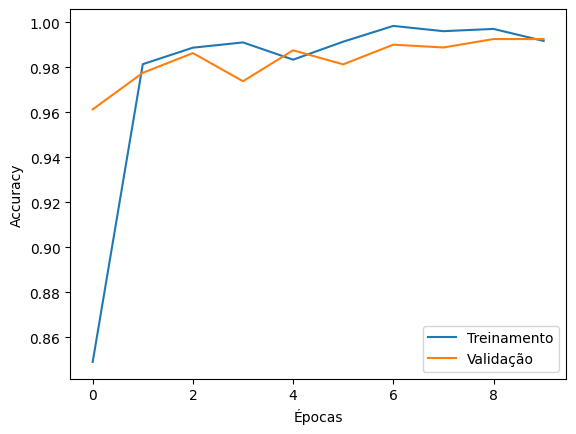

Avaliando o modelo no conjunto de teste...
Acurácia no Teste: 1.0, Loss: 0.007231569848954678


In [14]:
import matplotlib.pyplot as plt

# Treinamento final e avaliação com os melhores hiperparâmetros
print("Treinando o modelo com os melhores hiperparâmetros...")
best_model = create_cnn_model(int(best_num_neurons_gsa), best_learning_rate_gsa)
best_model_history = best_model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(x_validation, y_validation))

best_gsa_train_accuracy = best_model_history.history['accuracy'][-1]
best_gsa_validation_accuracy = best_model_history.history['val_accuracy'][-1]

print("Melhor Accuracy de Treinamento (CNN GSA):", best_gsa_train_accuracy)
print("Melhor Accuracy de Validação (CNN GSA):", best_gsa_validation_accuracy)

# Plotar as curvas de treino e validação
plt.plot(best_model_history.history['accuracy'], label='Treinamento')
plt.plot(best_model_history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("Avaliando o modelo no conjunto de teste...")
loss, accuracy = best_model.evaluate(x_test, y_test, verbose=0)

print(f"Acurácia no Teste: {accuracy}, Loss: {loss}")